# Classification Prediction with Imbalanced Target

# Mary Donovan Martello

## The goal of this project was to design predictive binary classification models to predict whether credit card account holders will default on their payments in the next month. The models address the imbalance in the target variable. This notebook uses a LASSO Logistic Regression model to make the default prediciton.

# Part 4:  LASSO Logistic Regression Model

In [2]:
# import libraries

import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')



### This notebook uses two datasets. The first dataset includes the full data that was cleaned, prepared, and transformed into Principal Component features in the 1_EDA_Prep notebook. The second dataset is the first dataset that has been reduced to the best select features identified in the 2_Test_Subsets_of_Features notebook.

In [4]:
# Load data into a dataframe

df = pd.read_csv('pcaDefault.csv')


### Need a dataframe with dummy features for probability prediction and the classifier threshold.

In [77]:

# convert categorical data to numbers 
#get the categorical data
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[cat_features]

# create dummy variable dataframe for categorical values 
dfDumm = pd.get_dummies(df_cat)

# check the data
print(dfDumm.head(4))

# create a whole features dataset that can be used for train and validation data splitting
# combine the numerical features and the dummie features together
dfNum = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'default'], axis = 1)
X = pd.concat([dfNum, dfDumm], axis=1)
# create a whole target dataset that can be used for train and validation data splitting
y =  df['default']


   SEX  EDUCATION  MARRIAGE
0    1          1         2
1    1          2         2
2    1          1         1
3    2          2         2


Check the input features for testing feature subsets.

In [8]:
X.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'SEX',
       'EDUCATION', 'MARRIAGE'],
      dtype='object')

In [9]:
X.shape

(30000, 11)

## Model Selection and Evaluation

**Create Feature Dataframe for GridSearch Pipeline**

In [6]:

# separate into input and output columns (X variable for features and y for target variables)

Xp = df.drop('default', axis = 1) 
yP = df['default']
# will not label encode the target variable for random forest model
yRFp = df['default']

# one-hot encode input variables
# use ColumnTransformer to indicate which categorical variables to encode
# https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
#https://github.com/scikit-learn/scikit-learn/issues/9132 to include categories = 'auto' when negative values in X
onehot_encoder = OneHotEncoder(categories='auto')
onehot_encoder.fit(Xp)
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [8, 9, 10])], remainder='passthrough')
Xp = transformer.fit_transform(Xp)

# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(yP)
yP = label_encoder.transform(yP)


**Phase 1: All input features with GridSearch and Stratified K-fold cross validation**

In [51]:
# grid search in a pipeline with lasso logistic regression


#Create lasso logistic regression pipeline and gridsearch
logit = LogisticRegression(penalty='l1', solver='liblinear')

param_logit={'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1']}

grid = GridSearchCV(logit, param_logit, cv=5, verbose=0)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'neg_log_loss']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           Xp, # Feature matrix
                           yP,#target vector
                           cv=skf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)

print (cv_results)
print("results")

{'fit_time': array([137.05733395, 166.88052583, 113.69085836, 133.211622  ,
       124.01712322,  76.53418684, 127.6055243 , 126.26012278,
       103.73639536,  83.25823951]), 'score_time': array([0.03390956, 0.02992129, 0.01496077, 0.02294135, 0.02095127,
       0.01595926, 0.04787564, 0.01196909, 0.00797606, 0.00662279]), 'test_accuracy': array([0.79606798, 0.79573476, 0.78940353, 0.78873709, 0.794     ,
       0.79266667, 0.78426142, 0.79393131, 0.79126375, 0.78526175]), 'train_accuracy': array([0.79095522, 0.79080707, 0.79139968, 0.7913256 , 0.79111111,
       0.79140741, 0.79219288, 0.7909707 , 0.79111885, 0.79208177]), 'test_precision_macro': array([0.72374057, 0.72327887, 0.7011063 , 0.6945062 , 0.71559987,
       0.71317813, 0.67095175, 0.7204641 , 0.70999388, 0.67693039]), 'train_precision_macro': array([0.70346411, 0.70262711, 0.70509778, 0.70590653, 0.70453668,
       0.70631341, 0.71001635, 0.70519681, 0.705007  , 0.70872374]), 'test_recall_macro': array([0.57473475, 0.5734

**Phase 2: Best subset of features with GridSearch and Stratified K-fold cross validation**

In [52]:
# subset grid search in a pipeline with lasso logistic regression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

#Create lasso logistic regression pipeline and gridsearch
logit = LogisticRegression(penalty='l1', solver='liblinear')

param_logit={'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1']}

grid = GridSearchCV(logit, param_logit, cv=5, verbose=0)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'neg_log_loss']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           subset7, # Feature matrix
                           yP,#target vector
                           cv=skf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)

print (cv_results)
print("results")

{'fit_time': array([5.24396586, 5.22701383, 5.29981875, 4.55680728, 4.18280339,
       4.30148625, 3.99330997, 4.29444456, 3.69803786, 3.43075609]), 'score_time': array([0.01496053, 0.03291059, 0.01894855, 0.01796103, 0.03789711,
       0.01695585, 0.01895213, 0.02493572, 0.0109725 , 0.01695371]), 'test_accuracy': array([0.79506831, 0.7934022 , 0.79006998, 0.78807064, 0.79      ,
       0.79266667, 0.78726242, 0.79259753, 0.78992998, 0.78459486]), 'train_accuracy': array([0.79062187, 0.79028853, 0.79043668, 0.79058484, 0.79088889,
       0.7902963 , 0.79119292, 0.79011888, 0.79015592, 0.79163735]), 'test_precision_macro': array([0.72303697, 0.71568555, 0.70571045, 0.69216867, 0.69888676,
       0.71797577, 0.68489874, 0.71679711, 0.70378102, 0.6738962 ]), 'train_precision_macro': array([0.70357607, 0.7019707 , 0.70267131, 0.70481238, 0.70525888,
       0.70289386, 0.70693014, 0.70281365, 0.70272496, 0.70866489]), 'test_recall_macro': array([0.57031947, 0.56763253, 0.5574071 , 0.5582796

**Best parameters from parameters tested in above GridSearch**

In [59]:
param_testLS = {'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1']}
LSsearch = GridSearchCV(estimator = LogisticRegression(penalty='l1', solver='liblinear'), 
param_grid = param_testLR, scoring='precision_macro',n_jobs=4,iid=False, cv=5)
LSsearch.fit(subset7, yP)
LSsearch.cv_results_, LSsearch.best_params_, LSsearch.best_score_

({'mean_fit_time': array([0.15774059, 0.077391  , 0.08317513, 0.081182  , 0.08337531,
         0.08098364, 0.08098269, 0.08317776, 0.08497367, 0.07679253]),
  'std_fit_time': array([0.04047471, 0.00629464, 0.00435419, 0.00580198, 0.00587102,
         0.00554953, 0.00656831, 0.00811622, 0.00940183, 0.01263112]),
  'mean_score_time': array([0.0633266 , 0.00797873, 0.00498796, 0.00398917, 0.00458741,
         0.00518608, 0.00618458, 0.00558453, 0.00698161, 0.00458779]),
  'std_score_time': array([0.02877262, 0.0014105 , 0.00154474, 0.0006303 , 0.00079763,
         0.00097631, 0.00097704, 0.00205153, 0.00356917, 0.00119727]),
  'param_C': masked_array(data=[1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425,
                     166.810054, 464.158883, 1291.54967, 3593.81366,
                     10000.0],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_penalty': m

### Probability Predictions and Classification Threshold Selection

**Fit the model with best paramaters from the above GridSearch**

In [60]:
# separate data into training and validation = full dataset from GridSearch had better results
XTrain, XTest, yTrain, yTest = train_test_split(X, y, stratify=y, test_size =0.3, random_state=11)

# use best parameters from above GridSearch
LS = LogisticRegression(C = 1.0, penalty = 'l1', solver='liblinear').fit(XTrain, yTrain)

**Make probability predictions to choose best classification threshold for imbalanced target.**

In [61]:
# choose the threshold with the Receiver Operating Characteristic curve and Youden's J statistic

# predict probabilities; the last part of this line keeps the probabilities for the positive outcome only
LSpredprob=LS.predict_proba(XTest)[:,1]

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(yTest, LSpredprob)

# get the best threshold: Youden’s J statistic
J = tpr - fpr
from numpy import argmax
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.238461


In [ ]:
# custom confusion matrix function to show percentages
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    
    return pd.DataFrame([[f'TN = {tn} (TNR = {tn / (tn+fp):1.2%})', 
                                f'FP = {fp} (FPR = {fp / (tn+fp):1.2%})'], 
                         [f'FN = {fn} (FNR = {fn / (fn+tp):1.2%})', 
                                f'TP = {tp} (TPR = {tp / (fn+tp):1.2%})']],
            index=['True 0(No Default)', 'True 1(Default)'], 
            columns=['Pred 0(No Default)', 
                            'Pred 1(Default)'])

**Use best threshold to convert probabilities to classification predictions**

In [62]:
# predprob are predicted possibilities for positive outcome prediction 
# allocate the probability predictions between 1 and 0 based on the best threshold
LSpredprob_tuned_thresh = np.where(LSpredprob >= 0.238461, 1, 0)

# custom confusion matrix with predictions (showing percentages)
conf_matLSthresh = conf_matrix(yTest, LSpredprob_tuned_thresh)
conf_matLSthresh

,Pred 0(No Default),Pred 1(Default)
True 0(No Default),TN = 5298 (TNR = 75.59%),FP = 1711 (FPR = 24.41%)
True 1(Default),FN = 784 (FNR = 39.38%),TP = 1207 (TPR = 60.62%)


**Visualize Confusion Matrix**

In [64]:
# need a different format of confusion matrix for visualizing the confusion matrix of predictions
from sklearn.metrics import confusion_matrix
conf_matLSthresh = confusion_matrix(yTest, LSpredprob_tuned_thresh)
print(conf_matLSthresh)

[[5298 1711]
 [ 784 1207]]


(array([0.5, 1.5]),
 [Text(0, 0.5, 'No Default Next Month'), Text(0, 1.5, 'Default Next Month')])

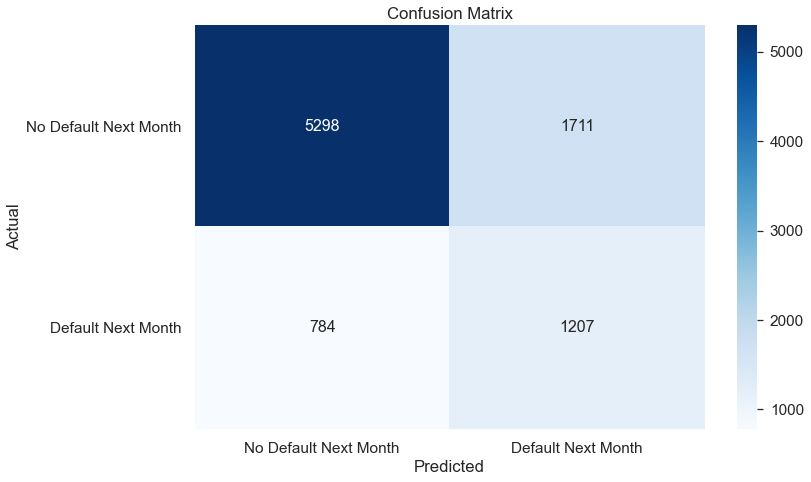

In [66]:
# seaborn confusion matrix
df_cm = pd.DataFrame(conf_matLSthresh, columns=np.unique(yP), index = np.unique(yP))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
x_axis_labels = ["No Default Next Month", "Default Next Month"] # labels for x-axis
y_axis_labels = ["No Default Next Month", "Default Next Month"] # labels for y-axis
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g', annot_kws={"size": 16}, xticklabels=x_axis_labels, yticklabels=y_axis_labels)# font size
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("Actual")
plt.xlabel("Predicted")
# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0)

**Classification Report to View Evaluation Metrics**

<AxesSubplot:>

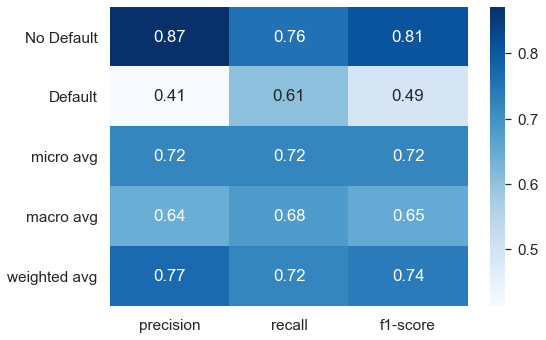

In [69]:
from sklearn.metrics import classification_report
class_repLSthresh = classification_report(yTest, LSpredprob_tuned_thresh, output_dict=True, target_names= ['No Default', 'Default'])
# Create a dataframe from the dictionary and plot a heatmap of it.
import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_repLSthresh).iloc[:-1, :].T, annot=True, cmap="Blues")

In [71]:
import joblib
# save the predicted probabilities
filename = 'LS_predProbs.sav'
joblib.dump(LSpredprob_tuned_thresh, filename)

['LS_predProbs.sav']

**Calculate Loss Scores for Imbalanced Targets**

In [72]:
# loss scores with probabilities

from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score

# the probabilities of the predictions were calcaulated above [below is the code used above]
#LSpredtst=LS.predict_proba(XTest)[:,1]

# calculate log loss
# In the binary classification case, the function takes a list of true outcome values and a list of probabilities as arguments 
      # and calculates the average log loss for the predictions.
LSlossLog = log_loss(yTest, LSpredprob)
LSlossBrier = brier_score_loss(yTest, LSpredprob)
LSlossAUC = roc_auc_score(yTest, LSpredprob)
print('Log Loss Score: ', LSlossLog)
print('Brier Loss Score: ', LSlossBrier)
print('AUC Score: ', LSlossAUC)

Log Loss Score:  0.470360046312647
Brier Loss Score:  0.15024409168996467
AUC Score:  0.7329405494936947
